# Overview

The goal of this notebook is to walkthrough sending glue jobs for data collection purposes. This example takes a bulk dataset from advance auto parts and collects daily visit counts to get summary stats on the daily level to view the daily trends.

# Dependencies

## Packages

In [11]:
import boto3
import pandas as pd
from configparser import ConfigParser
import os
import json
import plotly
import plotly.express as px
from plotly import graph_objects as go

## Credentials

In [12]:
PROFILE_ID='default'
config_object = ConfigParser()
config_object.read("/home/jovyan/.aws/credentials")
profile_info = config_object[PROFILE_ID]

ACCESS_KEY = profile_info.get('aws_access_key_id')
SECRET_KEY = profile_info.get('aws_secret_access_key')
AWS_SESSION_TOKEN = profile_info.get('aws_session_token')
REGION_NAME='us-west-2'
GLUE_ROLE="AWSGlueServiceRole-s3"

## Consants

In [13]:
BUCKET_NAME="jvs-fraud-research"

## Functions

In [14]:
def write_script_to_file(script_str, out_filepath):
    
    with open(out_filepath, 'w') as f:
        f.write(collect_script)
        
    print(f"Script file written to {out_filepath}")
    

# Collect Data

## Make Script and save to S3

Write templatized SQL to get summary stats on the data

In [15]:
temp_table_name = "visits"
sql = (
f"""
SELECT 
    visit_day,
    COUNT(visitor_id) num_visits
FROM {temp_table_name}
GROUP BY 
    visit_day
""")

In [16]:
data_source = "s3://jvs-fraud-research/advance_auto_glue_out_by_day"
dataset_name = "visit_counts_by_day"
data_sink = os.path.join("s3://", BUCKET_NAME, "datasets", dataset_name)
#data_sink = "s3://jvs-fraud-research/datasets/testing"

collect_script=(
f"""
from pyspark.context import SparkContext
from awsglue.context import GlueContext

sc = SparkContext()
glueContext = GlueContext(sc)
spark = glueContext.spark_session

df_visits = spark.read.parquet("{data_source}")
df_visits.createOrReplaceTempView("{temp_table_name}")

df_visit_counts_by_day = spark.sql(('''{sql}'''))
(
    df_visit_counts_by_day
    .coalesce(1)
    .write
    .format('csv')
    .option('header', True)
    .mode('overwrite')
    .option('sep',',')
    .save('{data_sink}')
)
"""
)

In [17]:
out_filepath = "scripts/get_visit_counts_by_day.py"
write_script_to_file(collect_script, out_filepath)

Script file written to scripts/get_visit_counts_by_day.py


### Use S3 client to move local script to S3

In [18]:
s3 = boto3.client(
    's3',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    aws_session_token=AWS_SESSION_TOKEN
)

In [19]:
s3.upload_file(out_filepath, BUCKET_NAME, out_filepath)

### Use Glue to run pyspark script

In [26]:
RUN_JOB=False

In [20]:
script_location = os.path.join("s3://", BUCKET_NAME, out_filepath)

In [21]:
glue = boto3.client(
    'glue',
    region_name=REGION_NAME,
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    aws_session_token=AWS_SESSION_TOKEN)

[Glue Client Documenation](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/glue.html#Glue.Client.create_job)

In [22]:
job = glue.create_job(Name='jvs_advance_daily_visit_summary', 
                      Role=GLUE_ROLE,
                      Command={
                          'Name': 'glueetl',
                          'ScriptLocation': script_location}
                     )
job_run = glue.start_job_run(JobName=job['Name'])

In [27]:
if RUN_JOB:
    status = glue.get_job_run(JobName=job['Name'], RunId=job_run['JobRunId'])
    print(json.dumps(status, default=str, indent=4))

## Load Transformed Data

In [24]:
filename = "visit_counts_data.csv"
download_filepath = os.path.join("/","home", "jovyan", "data", filename)
dataset_prefix = os.path.join("datasets", dataset_name)
bucket = boto3.resource("s3").Bucket(BUCKET_NAME)
objects = bucket.objects.filter(Prefix=dataset_prefix)

for obj in objects:
    bucket.download_file(obj.key, download_filepath)

# Explore the data

Fills the empty time periods with 0

In [29]:
def fill_empty_timestamps(df_, freq="D"):
    return (
        df_
        .sort_index()
        .asfreq(freq, fill_value=0)
        .assign(
            is_missing=lambda x: x.num_visits == 0
        )
    )

In [30]:
df = (
    pd.read_csv(download_filepath)
    .assign(visit_day=lambda x: pd.to_datetime(x.visit_day))
    .set_index("visit_day")
)
df = fill_empty_timestamps(df)
df.head()

,num_visits,is_missing
visit_day,,
2020-08-01,884740,False
2020-08-02,134344,False
2020-08-03,1,False
2020-08-04,112998,False
2020-08-05,760932,False


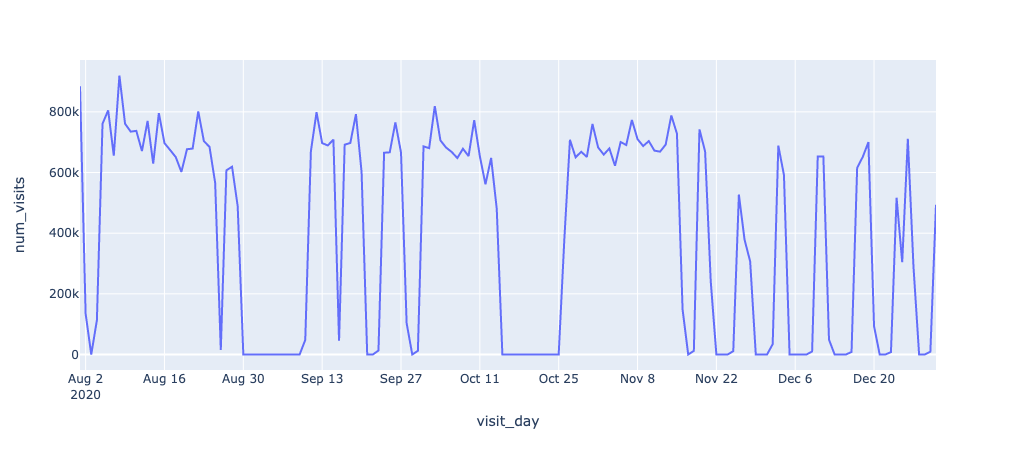

In [31]:
px.line(df, y="num_visits")

# Resources

* https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/glue.html  
* https://docs.aws.amazon.com/glue/latest/dg/aws-glue-programming-python-calling.html